<h1>Chapter 8 - Model-agnostic versus Model-specific Explainability </h1>
<p>This notebook is a reference for model-specific explainability method - Guided Integrated Gradients
<p>Author: Cher Simon

In [1]:
# install core and tf1 subpackages
!pip install saliency[tf1] tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [21]:
# load essential libraries
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
import saliency.tf1 as saliency
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%matplotlib inline

In [3]:
# download a classifier
classifier_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/3"

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

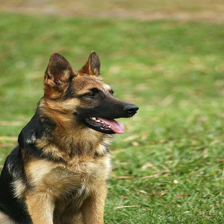

In [5]:
# load an image
im = Image.open("./gsdog.jpeg").resize(IMAGE_SHAPE)
im

In [6]:
im = np.array(im)/255.0
im.shape

(224, 224, 3)

In [7]:
# add a batch dimension with np.newaxis
result = classifier.predict(im[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
# find top class ID
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=236>

In [9]:
# decode the prediction
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [10]:
imagelist = []

with open(labels_path, "r") as file:
    for line in file:
        line = line.strip()  
        line = line.strip('"')  
        if line:  
            imagelist.append(line) 

In [11]:
imagelist

['background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python'

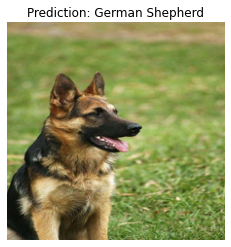

In [12]:
plt.imshow(im)
plt.axis('off')
predicted_class_name = imagelist[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [13]:
predicted_class_index = imagelist.index(predicted_class_name)
print("Predicted class index: " + str(predicted_class_index))

Predicted class index: 236


In [14]:
graph = tf.Graph()
sess = tf.Session(graph=graph)
with graph.as_default():
  hub.Module(classifier_model)
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())

In [15]:
with graph.as_default():
  images = graph.get_tensor_by_name('module/hub_input/images:0')
  logits = graph.get_tensor_by_name('module/InceptionV3/Logits/SpatialSqueeze:0')
  # Construct the scalar neuron tensor.
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[:,neuron_selector]
  prediction = tf.argmax(logits, 1)

In [16]:
# create saliency object
ig = saliency.IntegratedGradients(graph, sess, y, images)
guided_ig = saliency.GuidedIG(graph, sess, y, images)

In [17]:
# baseline for integrated gradient is a black image
baseline = np.zeros(im.shape)

In [18]:
# compute mask for integrated gradients and guided integrated gradients
ig_mask_3d = ig.GetMask(
  im, feed_dict = {neuron_selector: predicted_class_index}, x_steps=25, x_baseline=baseline, batch_size=20)
guided_ig_mask_3d = guided_ig.GetMask(
  im, feed_dict = {neuron_selector: predicted_class_index}, x_steps=25, x_baseline=baseline, max_dist=0.2, fraction=0.5)

In [24]:
# convert 3D tensors to 2D grayscale
ig_grayscale = saliency.VisualizeImageGrayscale(ig_mask_3d)
guided_ig_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

Text(0.5, 1.0, 'Guided Integrated Gradients')

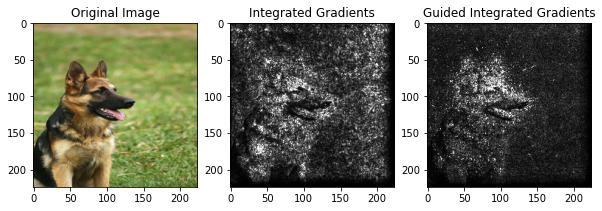

In [25]:
# visualize saliency maps
fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 3
  
fig.add_subplot(rows, columns, 1)
  
# show original
plt.imshow(im)
plt.title("Original Image")

fig.add_subplot(rows, columns, 2)
  
# show integrated gradients
plt.imshow(ig_grayscale, cmap="gray")
plt.title("Integrated Gradients")

fig.add_subplot(rows, columns, 3)
  
# show guided integrated gradients
plt.imshow(guided_ig_grayscale, cmap="gray")
plt.title("Guided Integrated Gradients")